In [1]:
import sys
cwd = "/Users/jordydikkers/personal/projects/machi-koro-ai"
sys.path.append(cwd)
import os
os.chdir(cwd)

In [2]:
import pickle
import torch
from buffer import Buffer, BigBuffer
import matplotlib.pyplot as plt
from env import GymMachiKoro, MachiKoro
from mcts_agent import MCTSAgent
import torch.nn as nn
import gym
import numpy as np


In [16]:
# for i in range(10):
#     with open(f"checkpoints/{i}.pkl", "rb") as file:
#         buffer = pickle.load(file)

#     buffer2 = BigBuffer(1, observation_space=buffer._observation_space, action_space=buffer._action_space)

#     buffer2.combine_buffers([buffer])
#     if buffer2._size != len(buffer2.obss):
#         a=1
#     with open(f"checkpoints2/{i}.pkl","wb") as file:
#         pickle.dump(buffer2, file)
    

In [3]:
buffers = []
for i in range(10):
    with open(f"checkpoints2/{i}.pkl", "rb") as file:
        buffers.append(pickle.load(file))

buffer = buffers[0].get_big_buffer()
buffer.combine_buffers(buffers)

buffer.post_process()

In [5]:
class PVNet(nn.Module):
    def __init__(
            self,
            observation_space: gym.Space,
            action_space: gym.Space,
    ):
        super().__init__()
        self.observation_space = observation_space
        self.action_space = action_space
        num_inputs = gym.spaces.flatten_space(observation_space).shape[0]
        num_outputs = action_space.n
        
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_outputs)

        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        
        x = torch.relu(self.fc2(x))
        # policy = self.fc3(x)
        x = torch.relu(self.fc4(x))
        value = torch.tanh(self.fc5(x))
        # return policy, value
        return value

    def predict(self, observation):
        input = torch.tensor(gym.spaces.flatten(self.observation_space, observation)).unsqueeze(0).to(torch.float32)
        # policy_pred, value_pred = self.forward(input)
        value_pred = self.forward(input)

        # policy_pred = torch.nn.functional.softmax(policy_pred, 1)

        # return policy_pred.squeeze().detach().numpy(), value_pred.detach().numpy().item()
        return value_pred.detach().numpy().item()

def loss_fn(policy_preds, value_preds, policy_targets, value_targets):
        # policy_loss = self.KLDiv(torch.nn.functional.log_softmax(policy_preds), torch.tensor(policy_targets).to(torch.float32))
        value_loss = torch.nn.functional.mse_loss(value_preds, torch.tensor(value_targets).to(torch.float32))
        return value_loss # + policy_loss

def train(train_buffer, val_buffer, pvnet, batch_size, epochs):
    
    optimizer = torch.optim.Adam(pvnet.parameters(), lr=0.001, weight_decay=1e-5)
    

    for epoch in range(epochs):
        train_batches = train_buffer.get_random_batches(batch_size = batch_size)

        tot_train_loss = 0
        train_steps_since_last_val_step = 0
        for i, batch in enumerate(train_batches):
            train_steps_since_last_val_step += 1
            obss, actions, rewards, next_obss, dones, player_ids, action_masks, values, probs = batch
            
            # policy_preds, value_preds = pvnet.forward(torch.tensor(obss).to(torch.float32))
            value_preds = pvnet.forward(torch.tensor(obss).to(torch.float32))
            loss = loss_fn(
                # policy_preds=policy_preds,
                policy_preds=0,
                value_preds=value_preds,
                # policy_targets=probs,
                policy_targets=0,
                value_targets=values
            )
            tot_train_loss += loss
            if i % 100 == 0:
                obss, actions, rewards, next_obss, dones, player_ids, action_masks, values, probs = val_buffer[:]
                # policy_preds, value_preds = pvnet.forward(torch.tensor(obss).to(torch.float32))
                value_preds = pvnet.forward(torch.tensor(obss).to(torch.float32))
                avg_val_loss = loss_fn(
                    # policy_preds=policy_preds,
                    policy_preds=0,
                    value_preds=value_preds,
                    # policy_targets=probs,
                    policy_targets=0,
                    value_targets=values
                )
                avg_train_loss = tot_train_loss/train_steps_since_last_val_step
                print(f"epoch: {epoch} | train_loss: {avg_train_loss} | val_loss: {avg_val_loss}")
                tot_train_loss = 0
                train_steps_since_last_val_step = 0
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return pvnet

In [14]:
env = MachiKoro(n_players=2)
env = GymMachiKoro(env)

pvnet = PVNet(env.observation_space, env.action_space)

In [31]:
buffer9 = buffers[-1]
buffer9.post_process()
train_buffer, val_buffer = buffer9.split_buffer(0.2)
pvnet = train(train_buffer=train_buffer, val_buffer=val_buffer, pvnet=pvnet, batch_size=64, epochs=5)


# policy_preds, value_preds = model.forward(torch.tensor(buffer.obss).to(torch.float32))

# fig, axs = plt.subplots(1, 1, tight_layout=True)

# # We can set the number of bins with the *bins* keyword argument.
# axs.hist(value_preds.detach().numpy().squeeze(), bins=100)

epoch: 0 | train_loss: 0.11722628027200699 | val_loss: 0.11627991497516632
epoch: 0 | train_loss: 0.09176701307296753 | val_loss: 0.0686754360795021
epoch: 0 | train_loss: 0.07282016426324844 | val_loss: 0.04723617807030678
epoch: 0 | train_loss: 0.06727480888366699 | val_loss: 0.048157308250665665
epoch: 0 | train_loss: 0.0501193143427372 | val_loss: 0.04726008325815201
epoch: 0 | train_loss: 0.05174778401851654 | val_loss: 0.04223967716097832
epoch: 1 | train_loss: 0.06100828945636749 | val_loss: 0.051566850394010544
epoch: 1 | train_loss: 0.03670654445886612 | val_loss: 0.029782960191369057
epoch: 1 | train_loss: 0.02745646797120571 | val_loss: 0.028118232265114784
epoch: 1 | train_loss: 0.03748879209160805 | val_loss: 0.03283189237117767
epoch: 1 | train_loss: 0.02981995791196823 | val_loss: 0.026273949071764946
epoch: 1 | train_loss: 0.02564811520278454 | val_loss: 0.025827504694461823
epoch: 2 | train_loss: 0.0037556560710072517 | val_loss: 0.023032328113913536
epoch: 2 | train_l

In [ ]:
n=0
for key, value in env.observation_space.items():
    print(key, value, n)
    if isinstance(value, gym.spaces.Box):
        n += 1
    else:
        n += value.n

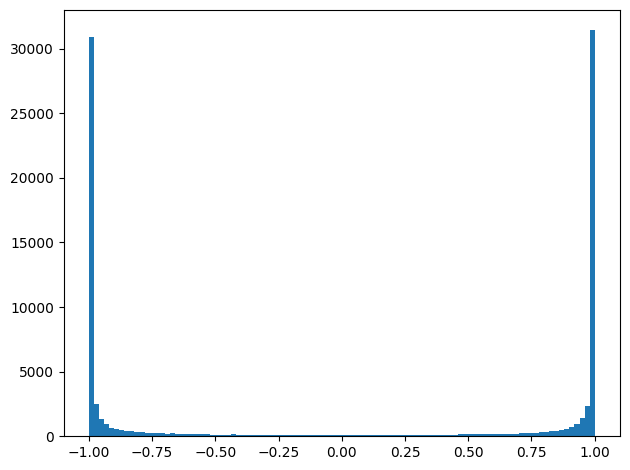

In [16]:
value_preds = pvnet.forward(torch.tensor(val_buffer.obss).to(torch.float32))

fig, axs = plt.subplots(1, 1, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs.hist(value_preds.detach().numpy().squeeze(), bins=100)
plt.show()

In [32]:
obss, actions, rewards, next_obss, dones, player_ids, action_masks, values, probs = buffer9.get_episode(0)
value_preds = pvnet.forward(torch.tensor(obss).to(torch.float32))

In [39]:
value_preds[50]

tensor([-1.0000], grad_fn=<SelectBackward0>)

In [33]:
p0_indices, _ = np.where(player_ids == 0)
p1_indices, _  = np.where(player_ids == 1)

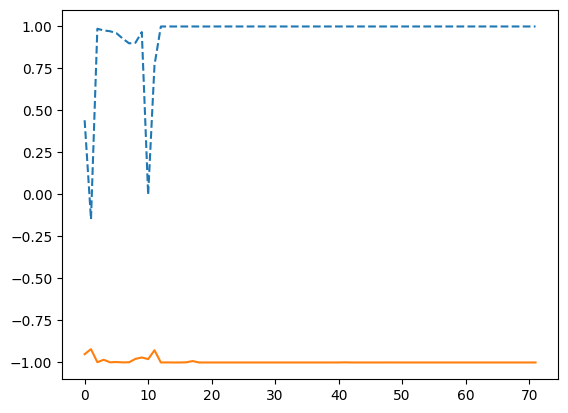

In [34]:
plt.plot(np.arange(len(p0_indices)), value_preds[p0_indices].detach().numpy(), "--")
plt.plot(np.arange(len(p1_indices)), value_preds[p1_indices].detach().numpy(), "-")
plt.show()